[View in Colaboratory](https://colab.research.google.com/github/Joejiong/GAN_PRCTICEs/blob/master/Pytorch_CGAN_with_GPU.ipynb)

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
9.73848620999999
GPU (s):
0.7930248270000106
GPU speedup over CPU: 12x


In [3]:
!pip install torch
!pip install matplotlib

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58750000 @  0x7fa1f319f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible
# np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

# show our beautiful painting range
# plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
# plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
# plt.legend(loc='upper right')
# plt.show()

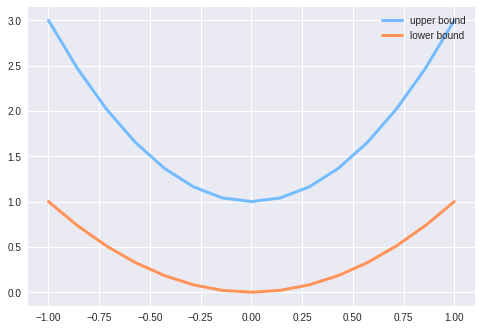

In [7]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [0]:
def artist_works_with_labels():     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    labels = (a-1) > 0.5            # upper paintings (1), lower paintings (0), two classes
    paintings = torch.from_numpy(paintings).float()
    labels = torch.from_numpy(labels.astype(np.float32))
    return paintings, labels

In [0]:
G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS+1, 128),          # random ideas (could from normal distribution) + class label
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS+1, 128),   # receive art work either from the famous artist or a newbie like G with label
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)


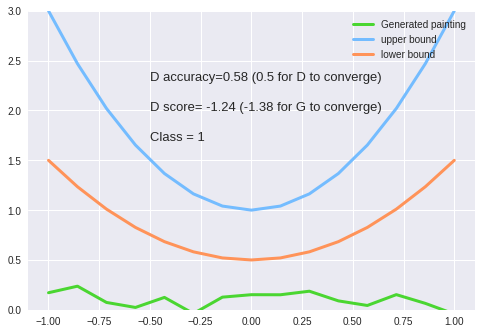

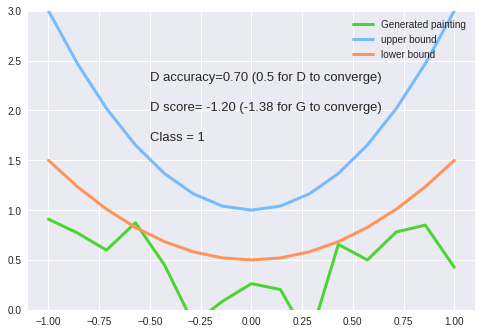

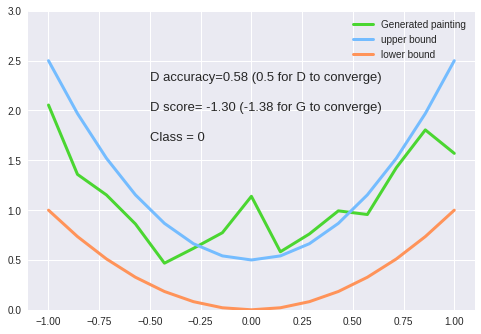

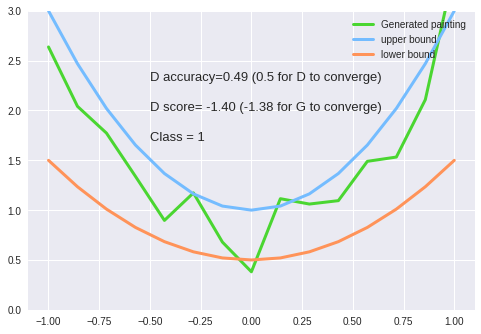

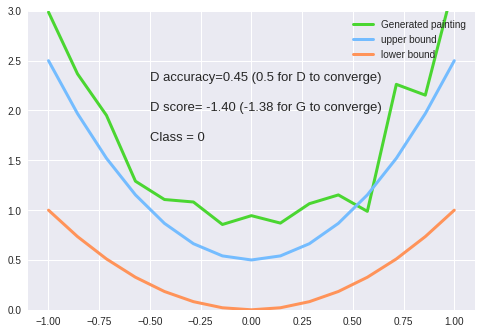

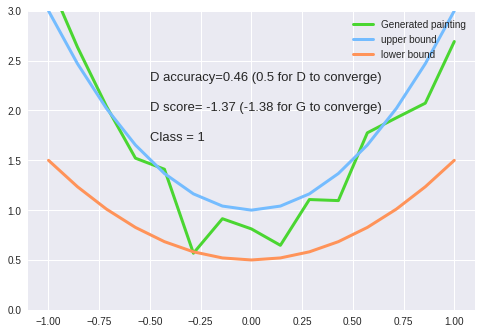

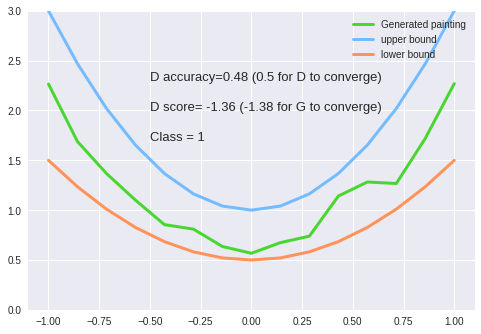

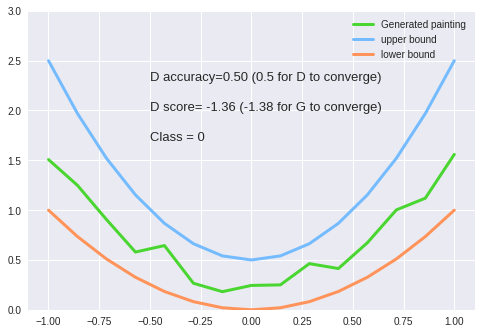

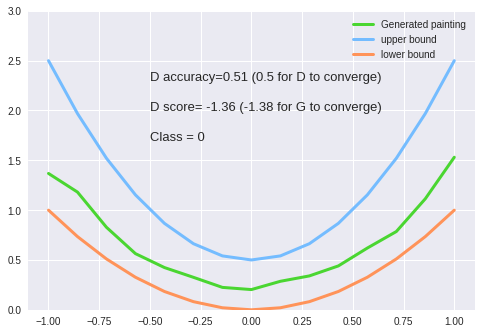

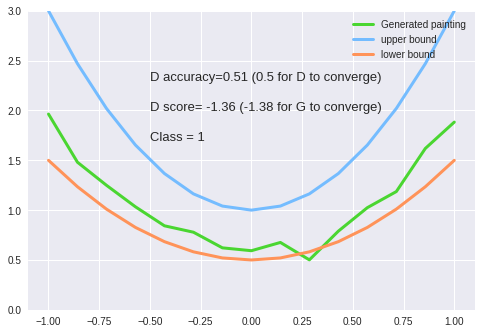

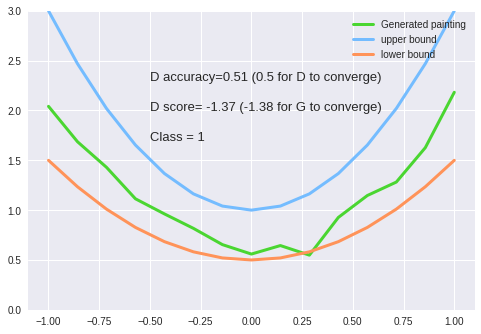

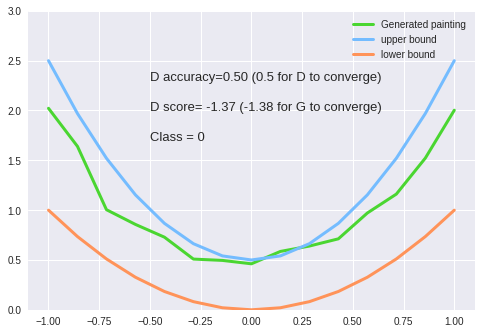

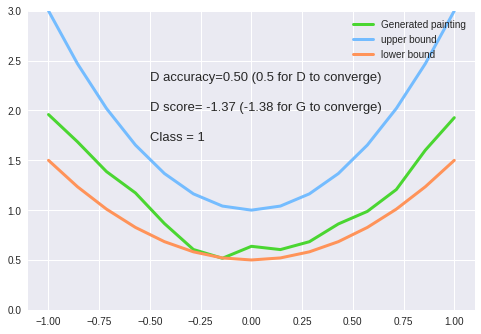

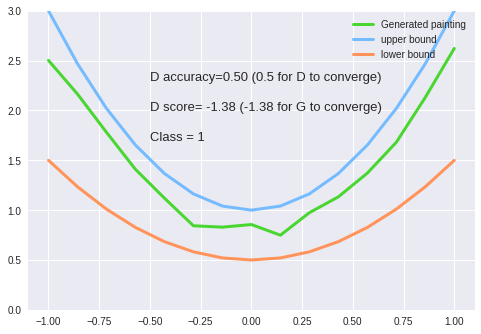

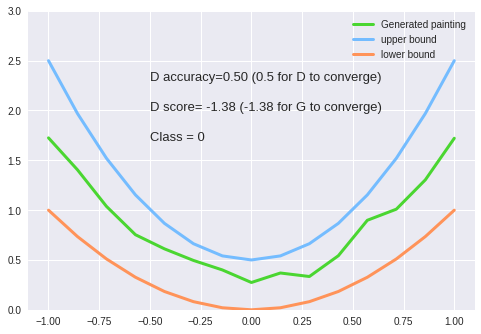

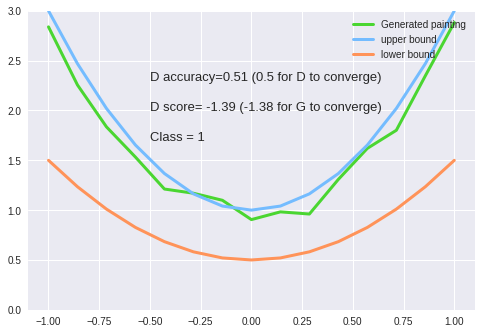

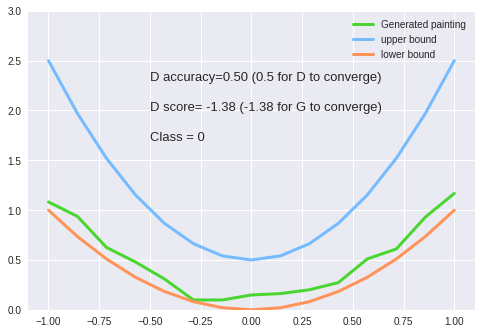

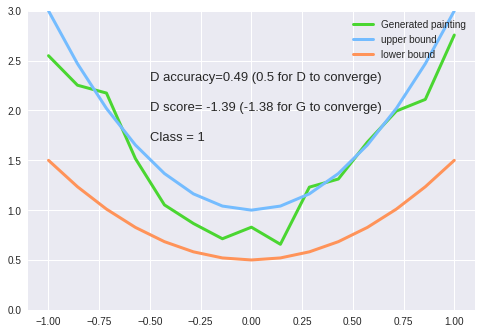

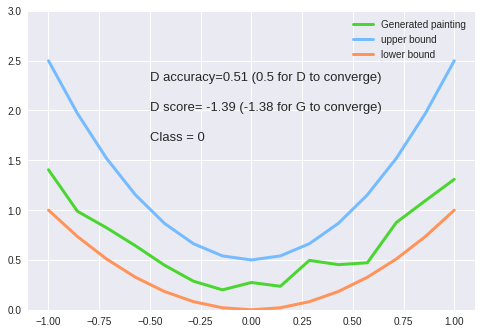

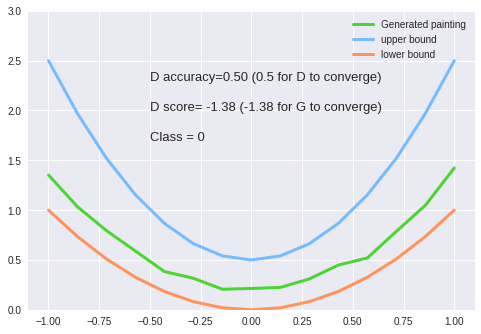

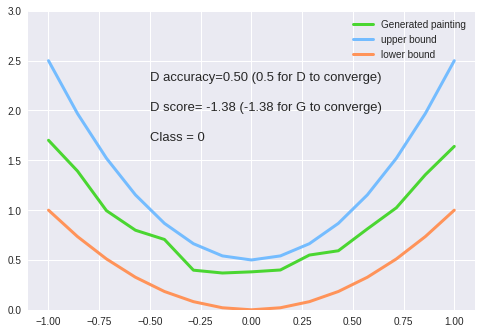

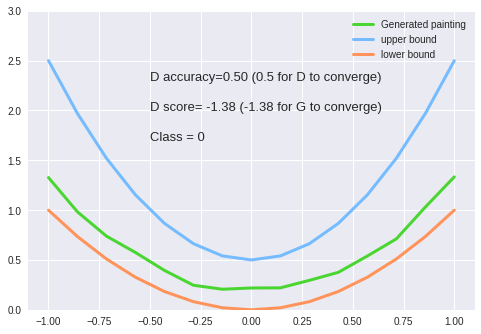

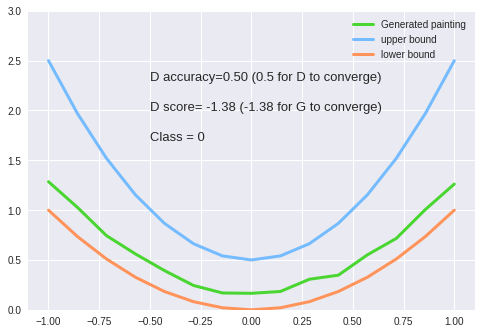

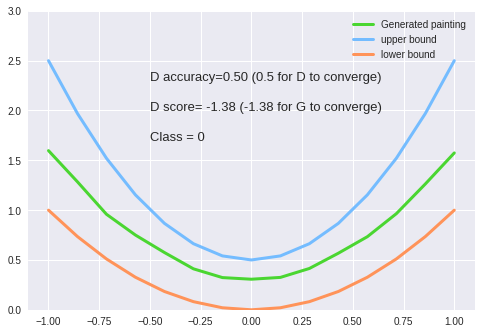

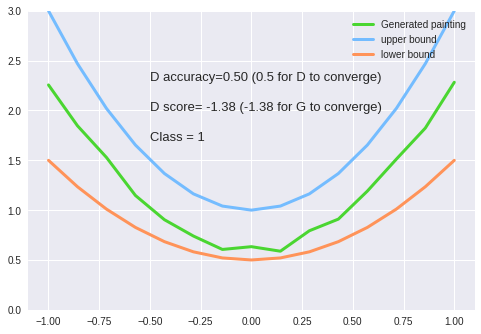

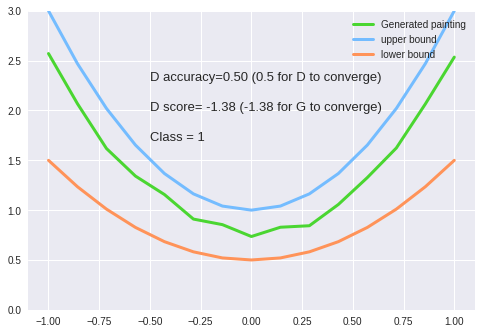

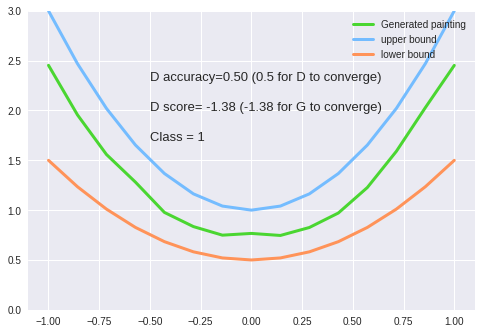

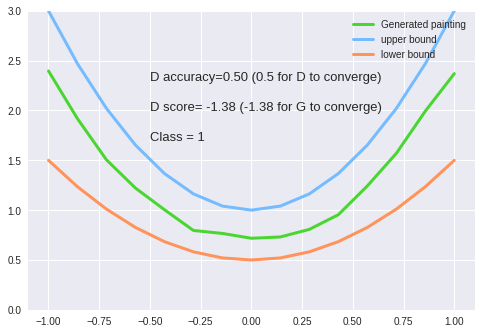

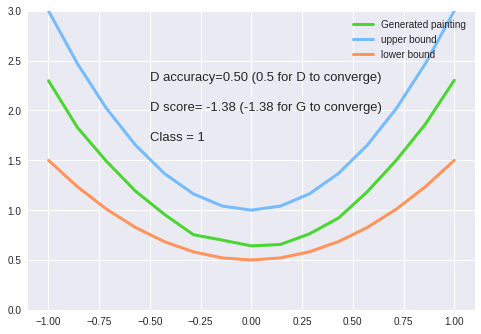

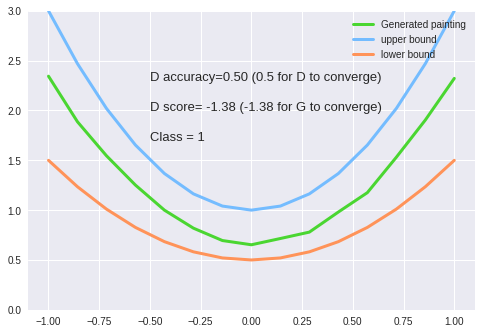

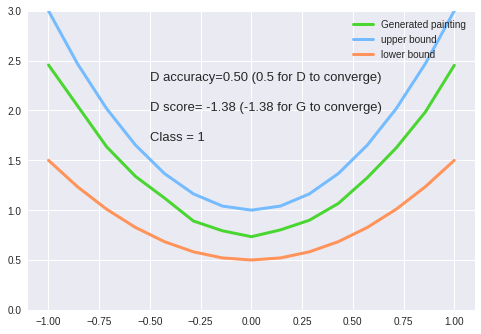

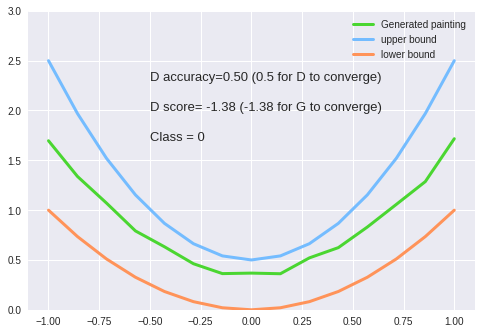

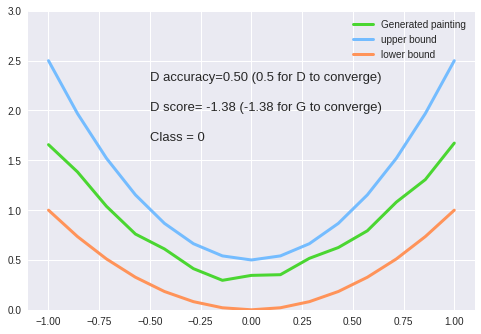

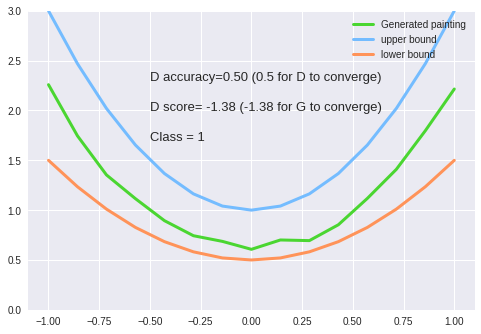

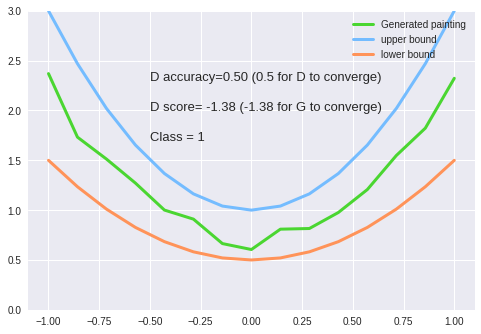

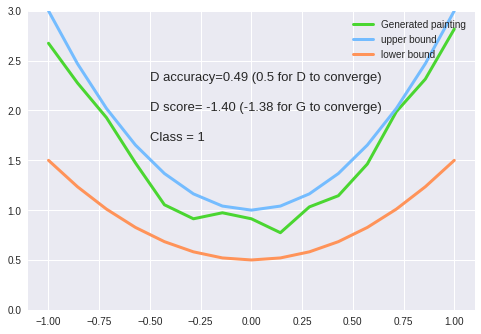

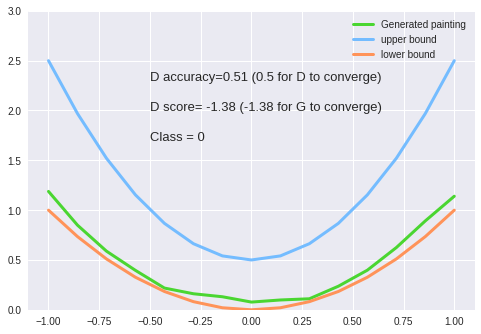

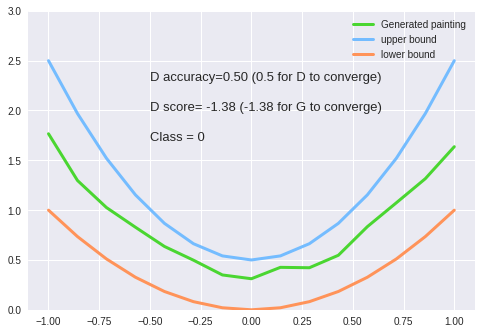

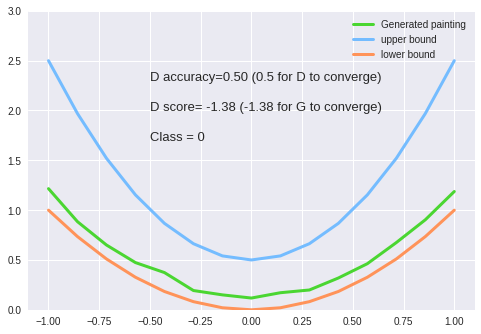

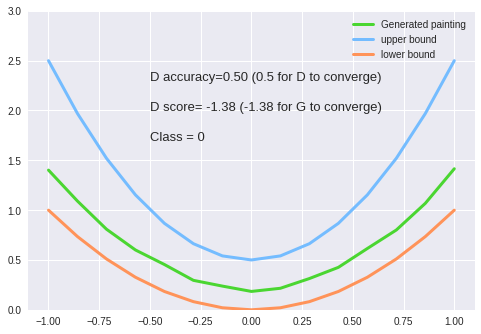

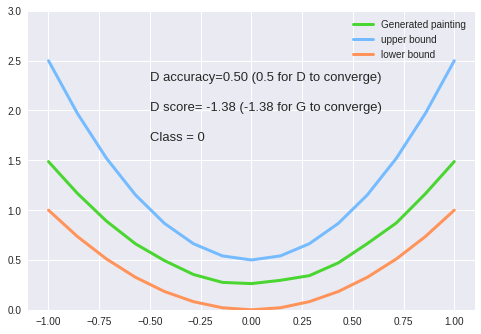

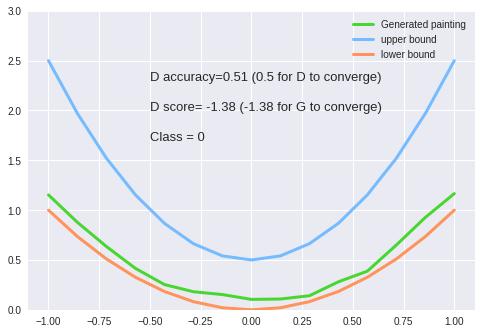

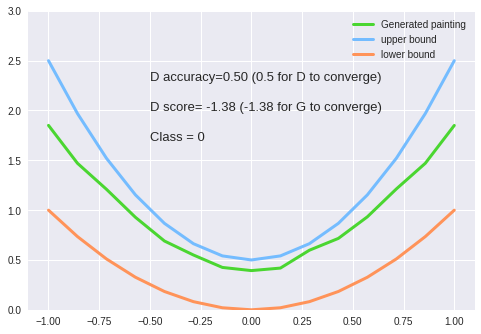

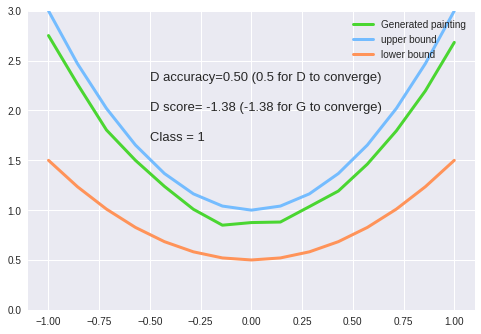

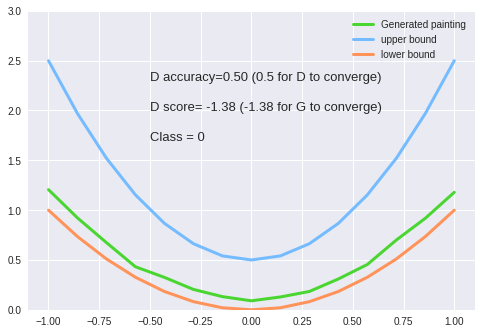

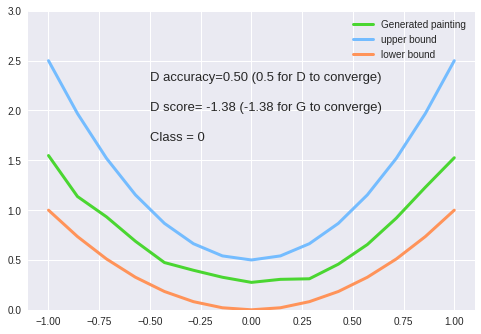

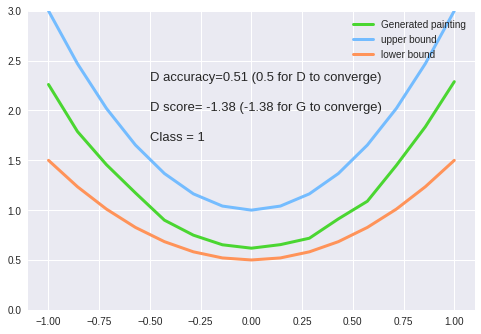

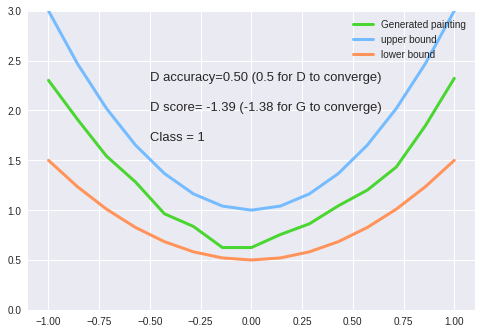

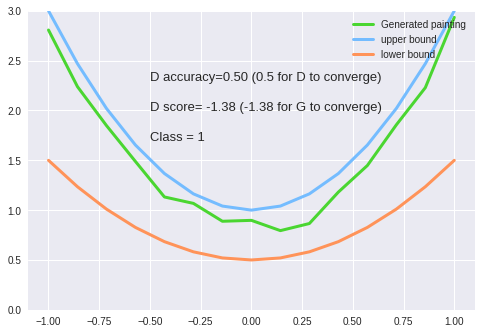

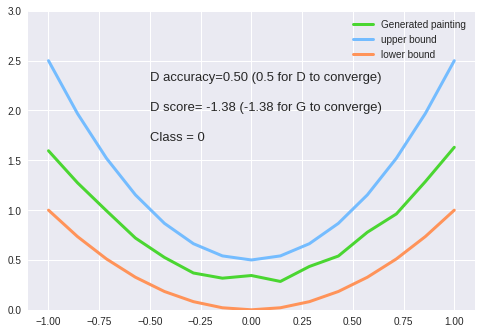

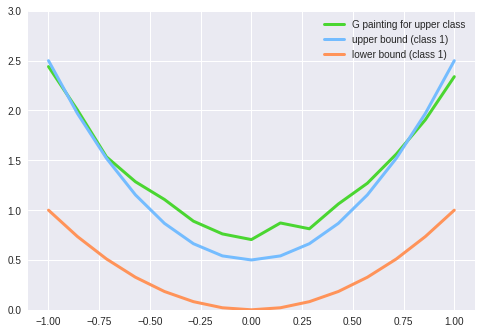

In [19]:
plt.ion()   # something about continuous plotting

for step in range(10000):
    artist_paintings, labels = artist_works_with_labels()           # real painting, label from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)                      # random ideas
    G_inputs = torch.cat((G_ideas, labels), 1)                      # ideas with labels
    G_paintings = G(G_inputs)                                       # fake painting w.r.t label from G

    D_inputs0 = torch.cat((artist_paintings, labels), 1)            # all have their labels
    D_inputs1 = torch.cat((G_paintings, labels), 1)
    prob_artist0 = D(D_inputs0)                 # D try to increase this prob
    prob_artist1 = D(D_inputs1)                 # D try to reduce this prob

    D_score0 = torch.log(prob_artist0)          # maximise this for D
    D_score1 = torch.log(1. - prob_artist1)     # maximise this for D
    D_loss = - torch.mean(D_score0 + D_score1)  # minimise the negative of both two above for D
    G_loss = torch.mean(D_score1)               # minimise D score w.r.t G

    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)      # reusing computational graph
    opt_D.step()

    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()

    if step % 200 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        bound = [0, 0.5] if labels.data[0, 0] == 0 else [0.5, 1]
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.text(-.5, 1.7, 'Class = %i' % int(labels.data[0, 0]), fontdict={'size': 13})
        plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.1)

plt.ioff()
plt.show()

# plot a generated painting for upper class
z = torch.randn(1, N_IDEAS)
label = torch.FloatTensor([[1.]])     # for upper class
G_inputs = torch.cat((z, label), 1)
G_paintings = G(G_inputs)
plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='G painting for upper class',)
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound (class 1)')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound (class 1)')
plt.ylim((0, 3));plt.legend(loc='upper right', fontsize=10);plt.show()